# Exercise 10 - Neural Network Representational Capacity
## Tasks
- Change the number of neurons in the hidden layers and the number of layers. Observe how the output changes and how the number of parameters changes (checked with summary from the torchsummary package).
-  Derive a formula for the number of trainable parameters assuming two input neurons, one output neuron, $N_d$ hidden layers with $N_w$ neurons each. What is the number of biases $N_b$ and
the number of weights $N_w$ ? Verify your result with the output from summary.

## Learning Goals
- Visualize and compare the potential neural network capacity of different architectures


## Attribution 
This task is inspired by https://github.com/FlorianMarquardt/machine-learning-for-physicists/blob/master/02_tutorial_completed_NetworkTrainingVisualization.ipynb.

In [8]:
import matplotlib.pyplot as plt
import torch
from torchsummary import summary

## Helper function

**weight initialization**

In [9]:
def initWeights(m):
    """Initialize weights of neural network with xavier initialization."""
    if (
            type(m) == torch.nn.Linear
            or type(m) == torch.nn.Conv2d
            or type(m) == torch.nn.Conv3d
    ):
        torch.nn.init.uniform_(m.weight, a=-10, b=10)
        torch.nn.init.uniform_(m.bias, a=-1, b=1)

**neural network definition**

In [10]:
class NN(torch.nn.Module):
    def __init__(
            self,
            inputDimension,
            hiddenDimensions,
            outputDimension,
            activationFunction=torch.nn.Tanh(),
    ):
        super().__init__()

        modules = []

        modules.append(torch.nn.Linear(inputDimension, hiddenDimensions[0]))
        modules.append(activationFunction)
        for i in range(len(hiddenDimensions) - 1):
            modules.append(
                torch.nn.Linear(hiddenDimensions[i], hiddenDimensions[i + 1])
            )
            modules.append(activationFunction)
        modules.append(torch.nn.Linear(hiddenDimensions[-1], outputDimension))

        self.model = torch.nn.Sequential(*modules)

    def forward(self, x):
        u = self.model(x)
        return u

## Neural network definition & sampling

**model definition**

In [11]:
torch.manual_seed(5)

numberOfHiddenNeurons = 100
numberOfLayers = 10

hiddenDimensions = [numberOfHiddenNeurons] * numberOfLayers
activationFunction = torch.nn.Sigmoid()
model = NN(2, hiddenDimensions, 1, activationFunction)
model.apply(initWeights)

# summarize the neural network and show number of trainable parameters
# the tuple is the input shape
summary(model, (1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]             300
           Sigmoid-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
           Sigmoid-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
           Sigmoid-6               [-1, 1, 100]               0
            Linear-7               [-1, 1, 100]          10,100
           Sigmoid-8               [-1, 1, 100]               0
            Linear-9               [-1, 1, 100]          10,100
          Sigmoid-10               [-1, 1, 100]               0
           Linear-11               [-1, 1, 100]          10,100
          Sigmoid-12               [-1, 1, 100]               0
           Linear-13               [-1, 1, 100]          10,100
          Sigmoid-14               [-1,

**grid definition**

In [12]:
Nx = 1000
Ny = 500

x = torch.linspace(-1, 1, Nx)
y = torch.linspace(-0.5, 0.5, Ny)
x, y = torch.meshgrid(x, y, indexing="ij")
input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
with torch.no_grad():
    output = model(input).detach().reshape((Nx, Ny))

## Post-processing

In [19]:
# matplotlib.use('qtagg')  # uncomment these 2 lines and restart kernel for interactive plot
# %matplotlib widget 

ValueError: 'qtagg' is not a valid value for backend; supported values are ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']

**output visualization**

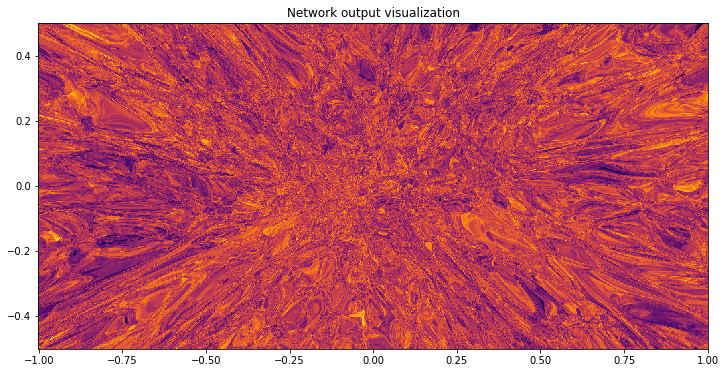

In [15]:
import matplotlib

fig, ax = plt.subplots(figsize=(12, 6))
cp = ax.pcolormesh(
    x, y, output, cmap=plt.cm.inferno, shading='auto'
)  # colormap inferno or plasma look great
plt.title('Network output visualization')
plt.show()

**zoomable output visualization**

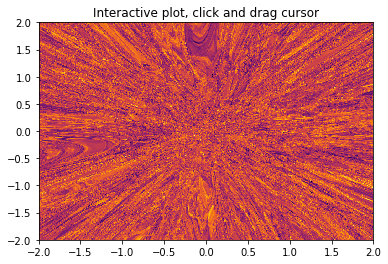

In [18]:
# Zoom into the network output by dragging and releasing cursor, as if dragging the 
# zoom tool, but just with cursor
# zoom thanks to: https://stackoverflow.com/questions/29821177/python-matplotlib-replot-on-zoom

class ZoomPlot():

    def __init__(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)
        self.xmin = -2.;
        self.xmax = 2.
        self.ymin = -2.;
        self.ymax = 2.
        self.xpress = self.xmin
        self.xrelease = self.xmax
        self.ypress = self.ymin
        self.yrelease = self.ymax
        self.resolution = 400
        self.maxiters = 30

        self.fig.canvas.mpl_connect('button_press_event', self.onpress)
        self.fig.canvas.mpl_connect('button_release_event', self.onrelease)
        self.plot_fixed_resolution(self.xmin, self.xmax,
                                   self.ymin, self.ymax)

    def plot_fixed_resolution(self, x1, x2, y1, y2):
        x = torch.linspace(x1, x2, self.resolution)
        y = torch.linspace(y1, y2, self.resolution)

        x, y = torch.meshgrid(x, y, indexing="ij")
        input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
        with torch.no_grad():
            output = model(input).detach().reshape((self.resolution, self.resolution))

        self.ax.clear()
        self.ax.set_xlim(x1, x2)
        self.ax.set_ylim(y1, y2)
        self.ax.pcolormesh(
            x, y, output, cmap=plt.cm.inferno, shading='auto')  # colormap inferno or plasma look great
        plt.title('Interactive plot, click and drag cursor')
        plt.show()
        self.fig.canvas.draw()

    def onpress(self, event):
        if event.button != 1: return
        self.xpress = event.xdata
        self.ypress = event.ydata

    def onrelease(self, event):
        if event.button != 1: return
        self.xrelease = event.xdata
        self.yrelease = event.ydata
        self.xmin = min(self.xpress, self.xrelease)
        self.xmax = max(self.xpress, self.xrelease)
        self.ymin = min(self.ypress, self.yrelease)
        self.ymax = max(self.ypress, self.yrelease)
        self.plot_fixed_resolution(self.xmin, self.xmax,
                                   self.ymin, self.ymax)


plot = ZoomPlot()